230130

모델 간소화

system 코드만 남김

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from openpyxl import Workbook

In [62]:
def hamiltonian_x(n = 20):
    x = np.linspace(0, 2*math.pi, n).reshape((-1, 1))
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    return x

def y_hamiltonian(x, w, idx, bias, y_n = 2): 
    '''
        y1(x) = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    w = w.v[idx]
    n = w.shape[0]

    y = bias
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y

def hamiltonian_loss(x, w):
    bias = [1, 0]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y1, y2 = [y_hamiltonian(x, w, idx = idx, bias = b) for idx, b in enumerate(bias)]
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)

        loss_1 = d_y1 + y2
        loss_2 = d_y2 - y1
        square_loss = tf.square(loss_1) + tf.square(loss_2)
        total_loss = tf.reduce_mean(square_loss)

        grad_w = tape.gradient(total_loss, w.trainable_variables)
    return grad_w, total_loss

def hamiltonian_w(n, y_n = 2):
    # custom train_x
    train_x = hamiltonian_x(n = 20)

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    w = tf.Module()
    w.v = tf.Variable(tf.random.normal(shape=(y_n, n), dtype=tf.float32))

    print('Start hamiltonian : {}차'.format(n))
    save_loss = 0
    for itr in range(10001):
        # custom loss
        grad_w, total_loss = hamiltonian_loss(train_x, w)
        optimizer.apply_gradients(zip(grad_w, w.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, y_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
    return w

Start hamiltonian : 1차
iter : 0, y_loss : 92.24754333496094
iter : 5000, y_loss : 0.2506706118583679
iter : 10000, y_loss : 0.25067052245140076
Start hamiltonian : 2차
iter : 0, y_loss : 546.06298828125
iter : 5000, y_loss : 1.0256210565567017
iter : 10000, y_loss : 0.10594905912876129
Start hamiltonian : 3차
iter : 0, y_loss : 12817.494140625
iter : 5000, y_loss : 56.91998291015625
iter : 10000, y_loss : 0.8958348035812378


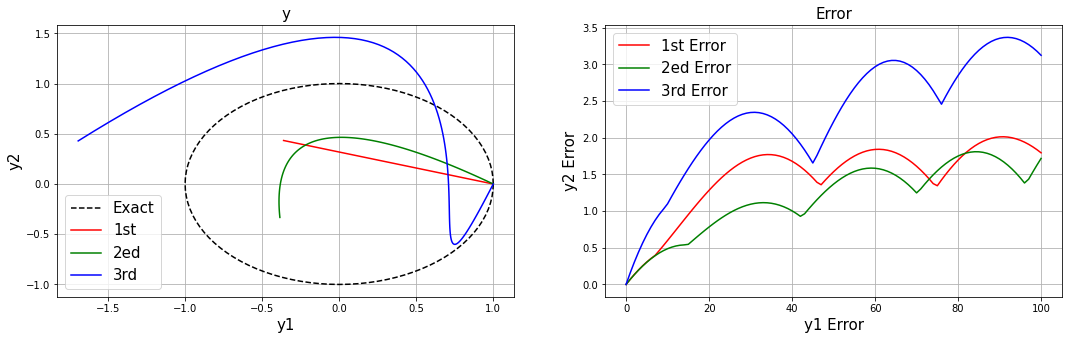

In [85]:
w_1 = hamiltonian_w(1)
w_2 = hamiltonian_w(2)
w_3 = hamiltonian_w(3)

# show_graph
test_x = np.linspace(0, 2*np.pi, 101, dtype = 'float32')
train_x = np.linspace(0, 2*math.pi, 20).reshape((-1, 1))

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

bias = [1, 0]
y11, y12 = [y_hamiltonian(test_x, w_1, idx = idx, bias = b) for idx, b in enumerate(bias)]
y21, y22 = [y_hamiltonian(test_x, w_2, idx = idx, bias = b) for idx, b in enumerate(bias)]
y31, y32 = [y_hamiltonian(test_x, w_3, idx = idx, bias = b) for idx, b in enumerate(bias)]

ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '--k', label = 'Exact')
ax.plot(y11, y12, '-r', label = '1st')
ax.plot(y21, y22, '-g', label = '2ed')
ax.plot(y31, y32, '-b', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()

# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - y11) + tf.abs(tf.math.sin(test_x) - y12), '-r', label = '1st Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y21) + tf.abs(tf.math.sin(test_x) - y22), '-g', label = '2ed Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y31) + tf.abs(tf.math.sin(test_x) - y32), '-b', label = '3rd Error')
ax2.set_xlabel('y1 Error', fontsize=15)
ax2.set_ylabel('y2 Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

Add EC

In [140]:
def model_create(n):
    model_dic = dict()
    for i in range(1, n+1):
        model_dic['model_{}'.format(i)] = tf.keras.models.Sequential([
            tf.keras.layers.Input((1,)),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 64, activation = 'tanh'),
            tf.keras.layers.Dense(units = 32, activation = 'tanh'),
            tf.keras.layers.Dense(units = 1)
        ])
        
    return model_dic

def y_hamiltonian_EC(x, w, NN, idx, bias):
    '''
        y1(x) = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y1_NN(x)*x
        y2(x) = w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n) + y2_NN(x)*x
    '''
    y = bias[idx]
    w = w.v[idx]
    n = w.shape[0]
    for i in range(1, n+1):
        y += w[i-1]*x**i

    return y + NN[idx](x)*x

def y_hamiltonian_EC_loss(x, w, y_NN, bias):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        
        y1 = y_hamiltonian_EC(x, w, y_NN, 0, bias)
        y2 = y_hamiltonian_EC(x, w, y_NN, 1, bias)
        d_y1 = tape.gradient(y1, x)
        d_y2 = tape.gradient(y2, x)

        loss_1 = d_y1 + y2
        loss_2 = d_y2 - y1

    square_loss = tf.square(loss_1) + tf.square(loss_2)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

def hamiltonian_EC_train(w):
    # custom train_x
    x = hamiltonian_x(n = 20)

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    # custom model
    model_dic = model_create(n=2)
    y_NN = list(model_dic.values())

    bias = [1, 0]
    save_loss = 0
    for itr in range(10001):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)

            # custom loss
            total_loss = y_hamiltonian_EC_loss(x, w, y_NN, bias)
            grad_y = tape.gradient(total_loss, [model.trainable_variables for model in y_NN])
        
        for grad, model in zip(grad_y, y_NN):
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

        if itr % 5000 == 0:
            print('iter : {}, hamiltonian_y_total_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss

            
    return y_NN

print('start w1 EC')
y1_NN = hamiltonian_EC_train(w_1)
print('start w2 EC')
y2_NN = hamiltonian_EC_train(w_2)
print('start w3 EC')
y3_NN = hamiltonian_EC_train(w_3)

start w1 EC
iter : 0, hamiltonian_y_total_loss : 5.9377851486206055
iter : 5000, hamiltonian_y_total_loss : 7.049775740597397e-05
iter : 10000, hamiltonian_y_total_loss : 8.154464012477547e-05
start w2 EC
iter : 0, hamiltonian_y_total_loss : 2.637657403945923
iter : 5000, hamiltonian_y_total_loss : 0.00019712334324140102
iter : 10000, hamiltonian_y_total_loss : 0.001743237255141139
start w3 EC
iter : 0, hamiltonian_y_total_loss : 4.629774570465088
iter : 5000, hamiltonian_y_total_loss : 0.0013020847691223025
iter : 10000, hamiltonian_y_total_loss : 0.003312318818643689


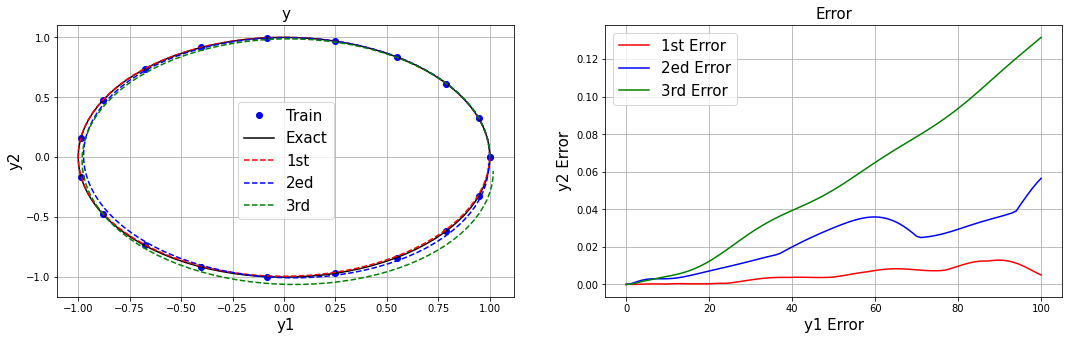

In [141]:
# wb = Workbook()
# ws1 = wb.active
# ws1.title = '1차_EC y1_y2'
# ws2 = wb.create_sheet(title = '2차 y1_y2')
# ws3 = wb.create_sheet(title = '3차 y1_y2')

# show_graph
test_x = np.linspace(0, 2*np.pi, 101, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*np.pi, 20).reshape(-1, 1)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

y11_EC, y12_EC = y_hamiltonian_EC(test_x, w_1, y1_NN, 0, bias), y_hamiltonian_EC(test_x, w_1, y1_NN, 1, bias)
y21_EC, y22_EC = y_hamiltonian_EC(test_x, w_2, y2_NN, 0, bias), y_hamiltonian_EC(test_x, w_2, y2_NN, 1, bias)
y31_EC, y32_EC = y_hamiltonian_EC(test_x, w_3, y3_NN, 0, bias), y_hamiltonian_EC(test_x, w_3, y3_NN, 1, bias)

# for y1, y2 in zip(y11_EC, y12_EC):
#     ws1.append(list(map(float, [y1, y2])))
# for y1, y2 in zip(y21_EC, y22_EC):
#     ws2.append(list(map(float, [y1, y2])))
# for y1, y2 in zip(y31_EC, y32_EC):
#     ws3.append(list(map(float, [y1, y2])))

# wb.save('expansion20230102_Example4_exel_yEC.xlsx')

ax.plot(tf.math.cos(train_x), tf.math.sin(train_x), 'ob', label = 'Train')
ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '-k', label = 'Exact')
ax.plot(y11_EC, y12_EC, '--r', label = '1st')
ax.plot(y21_EC, y22_EC, '--b', label = '2ed')
ax.plot(y31_EC, y32_EC, '--g', label = '3rd')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - y11_EC) + tf.abs(tf.math.sin(test_x) - y12_EC), '-r', label = '1st Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y21_EC) + tf.abs(tf.math.sin(test_x) - y22_EC), '-b', label = '2ed Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y31_EC) + tf.abs(tf.math.sin(test_x) - y32_EC), '-g', label = '3rd Error')
ax2.set_xlabel('y1 Error', fontsize=15)
ax2.set_ylabel('y2 Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

In [19]:
def hamiltonian_PINN_train():
    wb = Workbook()
    ws1 = wb.active
    ws1.title = 'total'

    x = np.linspace(0, 2*math.pi, 20).reshape((-1, 1))
    x = x.reshape(-1, 1)    # (x크기, 1)
    x = tf.constant(x, dtype = tf.float32)  # tensor 상수로 변형

    learning_rate = 1e-3
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

    y1_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    y2_NN = tf.keras.models.Sequential([
        tf.keras.layers.Input((1,)),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 64, activation = 'tanh'),
        tf.keras.layers.Dense(units = 32, activation = 'tanh'),
        tf.keras.layers.Dense(units = 1)
    ])

    save_loss = 0
    for itr in range(10001):
        with tf.GradientTape() as tape:
            tape.watch(x)
            with tf.GradientTape() as tape_y1:
                tape_y1.watch(x)

                y1 = y1_NN(x)
                d_y1 = tape_y1.gradient(y1, x)

            with tf.GradientTape() as tape_y2:
                tape_y2.watch(x)

                y2 = y2_NN(x)
                d_y2 = tape_y2.gradient(y2, x)

            loss_1 = d_y1 + y2
            loss_2 = d_y2 - y1
            loss_y1_init = tf.ones([1, 1]) - y1_NN(tf.zeros([1, 1]))
            loss_y2_init = tf.zeros([1, 1]) - y2_NN(tf.zeros([1, 1]))
            square_loss = tf.square(loss_1) + tf.square(loss_2) + tf.square(loss_y1_init) + tf.square(loss_y2_init)
            total_loss = tf.reduce_mean(square_loss)

            grad_y1_NN, grad_y2_NN = tape.gradient(total_loss, [y1_NN.trainable_variables, y2_NN.trainable_variables])
            optimizer.apply_gradients(zip(grad_y1_NN, y1_NN.trainable_variables))
            optimizer.apply_gradients(zip(grad_y2_NN, y2_NN.trainable_variables))

        ws1.append(list(map(float, [total_loss])))

        if itr % 5000 == 0:
            print('iter : {}, hamiltonian_y_total_loss : {}'.format(itr, total_loss.numpy()))
            if save_loss == total_loss: break
            save_loss = total_loss
    wb.save('expansion20230102_Example4_exel_PINN_loss.xlsx')
    return y1_NN, y2_NN

print('start w1 EC')
y1_PINN, y2_PINN = hamiltonian_PINN_train()

start w1 EC
iter : 0, hamiltonian_y_total_loss : 1.479361891746521
iter : 5000, hamiltonian_y_total_loss : 0.002205983502790332
iter : 10000, hamiltonian_y_total_loss : 5.111515201861039e-05


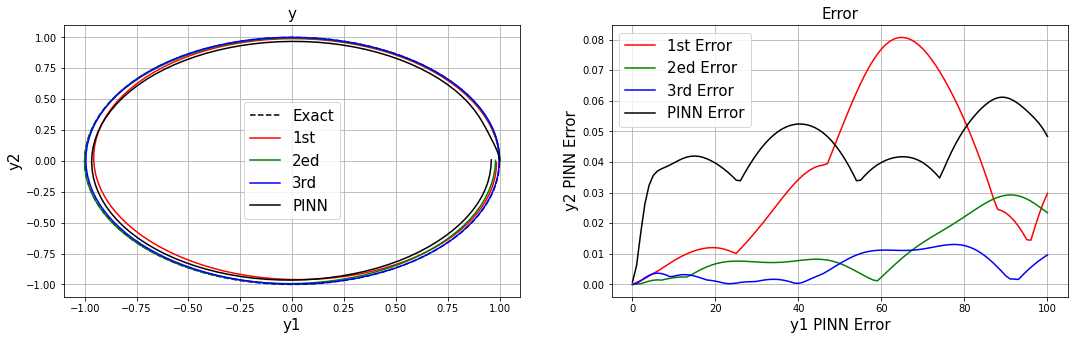

In [24]:
# show_graph
wb = Workbook()
ws1 = wb.active
ws1.title = '1차_EC y1_y2'
ws2 = wb.create_sheet(title = '2차 y1_y2')
ws3 = wb.create_sheet(title = '3차 y1_y2')
ws4 = wb.create_sheet(title = 'PINN y1_y2')

test_x = np.linspace(0, 2*np.pi, 101, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*np.pi, 20).reshape(-1, 1)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

for y1, y2 in zip(y11_EC, y12_EC):
    ws1.append(list(map(float, [y1, y2])))
for y1, y2 in zip(y21_EC, y22_EC):
    ws2.append(list(map(float, [y1, y2])))
for y1, y2 in zip(y31_EC, y32_EC):
    ws3.append(list(map(float, [y1, y2])))
for y1, y2 in zip(y1_PINN(test_x), y2_PINN(test_x)):
    ws4.append(list(map(float, [y1, y2])))

wb.save('expansion20230102_Example4_exel_yEC_PINN.xlsx')

# ax.plot(tf.math.cos(train_x), tf.math.sin(train_x), 'ob', label = 'Train')
ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '--k', label = 'Exact')
ax.plot(y11_EC, y12_EC, '-r', label = '1st')
ax.plot(y21_EC, y22_EC, '-g', label = '2ed')
ax.plot(y31_EC, y32_EC, '-b', label = '3rd')
ax.plot(y1_PINN(test_x), y2_PINN(test_x), '-k', label = 'PINN')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - y11_EC) + tf.abs(tf.math.sin(test_x) - y12_EC), '-r', label = '1st Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y21_EC) + tf.abs(tf.math.sin(test_x) - y22_EC), '-g', label = '2ed Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y31_EC) + tf.abs(tf.math.sin(test_x) - y32_EC), '-b', label = '3rd Error')
ax2.plot(tf.abs(tf.math.cos(test_x) - y1_PINN(test_x)) + tf.abs(tf.math.sin(test_x) - y2_PINN(test_x)), '-k', label = 'PINN Error')
ax2.set_xlabel('y1 PINN Error', fontsize=15)
ax2.set_ylabel('y2 PINN Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()

In [15]:
ex4_w_3 = hamiltonian_w(3)

print('start w3 EC')
ex4_y31_NN, ex4_y32_NN = hamiltonian_EC_train(ex4_w_3)

print('start PINN')
ex4_y1_PINN, ex4_y2_PINN = hamiltonian_PINN_train()

Start hamiltonian : 3차
iter : 0, y_loss : 12399.6376953125
iter : 5000, y_loss : 50.29058837890625
iter : 10000, y_loss : 3.2855918407440186
start w3 EC
iter : 0, hamiltonian_y_total_loss : 29.667072296142578
iter : 5000, hamiltonian_y_total_loss : 0.00023951797629706562
iter : 10000, hamiltonian_y_total_loss : 0.0009568530367687345
start PINN
iter : 0, hamiltonian_y_total_loss : 1.0892612934112549
iter : 5000, hamiltonian_y_total_loss : 3.924465272575617e-05
iter : 10000, hamiltonian_y_total_loss : 4.195245128357783e-05


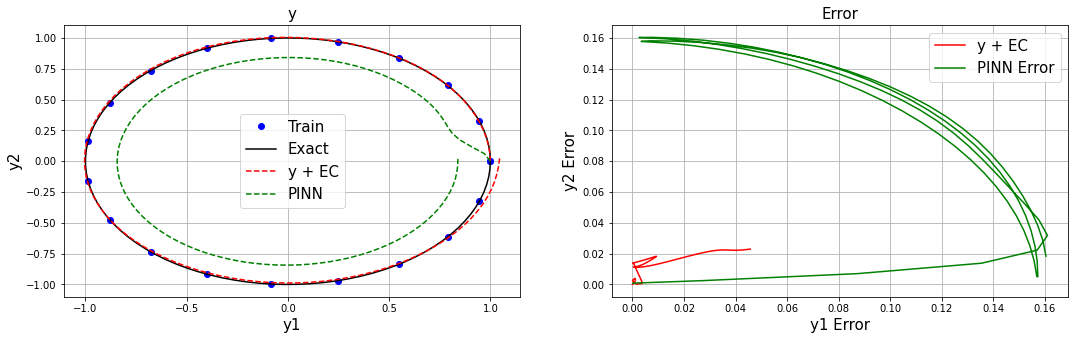

In [17]:
# show_graph
test_x = np.linspace(0, 2*np.pi, 100, dtype = 'float32').reshape(-1, 1)
train_x = np.linspace(0, 2*np.pi, 20).reshape(-1, 1)

ex4_y31_EC, ex4_y32_EC = y_hamiltonian_EC(test_x, ex4_w_3, ex4_y31_NN, bias = 1), y_hamiltonian_EC(test_x, ex4_w_3, ex4_y32_NN, bias = 0)

fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)

ax.plot(tf.math.cos(train_x), tf.math.sin(train_x), 'ob', label = 'Train')
ax.plot(tf.math.cos(test_x), tf.math.sin(test_x), '-k', label = 'Exact')
ax.plot(ex4_y31_EC, ex4_y32_EC, '--r', label = 'y + EC')
ax.plot(ex4_y1_PINN(test_x), ex4_y2_PINN(test_x), '--g', label = 'PINN')
ax.set_xlabel('y1', fontsize=15)
ax.set_ylabel('y2', fontsize=15)
ax.set_title('y', fontsize=15)
ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(tf.abs(tf.math.cos(test_x) - ex4_y31_EC), tf.abs(tf.math.sin(test_x) - ex4_y32_EC), '-r', label = 'y + EC')
ax2.plot(tf.abs(tf.math.cos(test_x) - ex4_y1_PINN(test_x)), tf.abs(tf.math.sin(test_x) - ex4_y2_PINN(test_x)), '-g', label = 'PINN Error')
ax2.set_xlabel('y1 Error', fontsize=15)
ax2.set_ylabel('y2 Error', fontsize=15)
ax2.set_title('Error', fontsize=15)
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=15)
ax2.grid()